# Automatic Differentiation

In [1]:
using Plots

## How to find derivatives of functions

Suppose we want to find the slope of a function

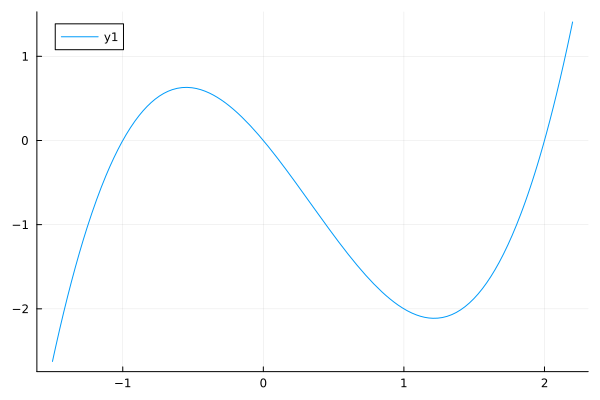

In [2]:
f(x)=(x+1)*x*(x-2)
plot(f,-1.5,2.2)

In this particular case, we can do it analytically.  

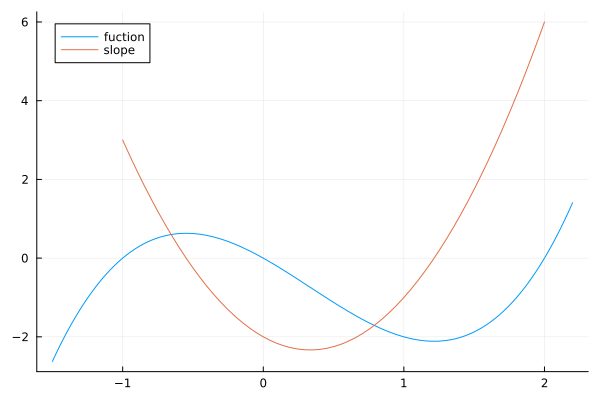

In [3]:
dfdx(x)=3*x^2-2*x-2
plot(f,-1.5,2.2,label="fuction")
plot!(dfdx,-1,2,label="slope")

An obvious approach, is to use finite differences
$$
\frac{df}{dx} \approx \frac{f(x+\delta)-f(x)}{\delta}+O(\delta^2)
$$
One just makes $\delta$ small enough and one should approximate the derivative.  A better approximation is
$$
\frac{df}{dx} \approx \frac{f(x+\delta)-f(x-\delta)}{2\delta}+O(\delta^3)
$$

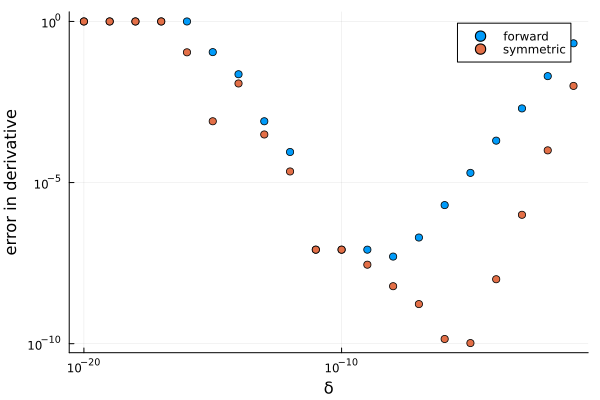

In [4]:
approxder1(func,x,delta)=(func(x+delta)-func(x))/(delta)
approxder2(func,x,delta)=(func(x+delta)-func(x-delta))/(2*delta)
deltalist=[(10.)^-s for s in 1:20]
derlist1=[abs(approxder1(f,1.,delta)-dfdx(1)) for delta in deltalist]
derlist2=[abs(approxder2(f,1.,delta)-dfdx(1)) for delta in deltalist]
scatter(deltalist,derlist1,xscale=:log10,yscale=:log10,xlabel="δ",ylabel="error in derivative",label="forward")
scatter!(deltalist,derlist2,label="symmetric")

Indeed, the symmetric derivative formula is orders of magnitude better than the forward formula, but the error is actually non-monotonic in the difference $\delta$.  The reason for this is round-off error.  There are tricks to mitigate this error, for example

In [5]:
function approxder3(func,x,delta)
    x2=x+delta
    x1=x-delta
    return (func(x2)-func(x1))/(x2-x1)
end

derlist3=[abs(approxder3(f,1.,delta)-dfdx(1)) for delta in deltalist]
derlist3

20-element Vector{Float64}:
   0.009999999999999454
   9.999999999177334e-5
   9.999999162069173e-7
   1.000088900582341e-8
   1.0547118733938987e-10
   1.6653345369377348e-10
   1.6653345369377348e-9
   5.551115123125783e-9
   5.551114967694559e-8
   0.0
   0.0
   5.5509297807398994e-5
   0.0005552470849528035
   0.011111111111111072
   0.052631578947368474
   1.0
 NaN
 NaN
 NaN
 NaN

As you can see, we actually got the exact result (to machine precision) with that trick, with the appropriate $\delta$.  The reason this trick helped is that with round-off error $(x+\delta)-(x-\delta)$ is not exactly equal to $2\delta$.  The `NaN`'s in the end mean "Not a Number".  That came from dividing by zero -- for those really small $\delta$'s $x+\delta=x-\delta$. 

The problem with using finite diferences for derivatives is that it is expensive.  We needed 2 function evaluations to approximate the derivative.  If we have a function of $N$ variables, we would need $2*N$ evaluations to find the gradient. 

You will find code out there that uses finite differences to approximate derivatives.  The modern solution, however, is *Automatic Differentiation*, where we algorithmically step through a program, calculating the derivatives as we go.

There are two flavors of Automatic Differentiation:  *Forward* and *backward*.  I'll mainly focus on the Forward method in this lecture.

## Dispatch, methods, types and overloading

Every object in any programming language has a type

In [6]:
@show typeof(1.2)
@show typeof(1)
@show typeof(sin)
@show typeof([1,2,3])
@show typeof(1:5);

typeof(1.2) = Float64
typeof(1) = Int64
typeof(sin) = typeof(sin)
typeof([1, 2, 3]) = Vector{Int64}
typeof(1:5) = UnitRange{Int64}


Julia combines features of dynamically typed languages (like Python) and statically typed languages (like C).  So far we have essentially been treating it as if it is solely dynamically typed.  We are, now, going to take advantage of the fact that we can make functions (called `methods`) which behave differently, depending on the type of the object which they are called with.  This programming strategy is called *multiple dispatch*.  For example, here is a function which returns `1` when called with an integer, and `0` if called by a floating point number. 

In [7]:
real_or_int(x::Integer)=1
real_or_int(x::AbstractFloat)=0

real_or_int (generic function with 2 methods)

In [8]:
@show real_or_int(1.2)
@show real_or_int(3);

real_or_int(1.2) = 0
real_or_int(3) = 1


This is particularly useful when defining our own data types.  It allows us to overload the standard arithmetic operations:

In [9]:
struct quaternion
    a
    i
    j
    k
end

Base.:+(a::quaternion,b::quaternion)=quaternion(a.a+b.a,a.i+b.i,a.j+b.j,a.k+b.k)
Base.:*(a::quaternion,b::quaternion)=quaternion(
    a.a*b.a-a.i*b.i-a.k*b.k,
    a.a*b.i+a.i*b.a+a.j*b.k-a.k*b.j,
    a.a*b.j+a.j*b.a+ a.k*b.i-a.i*b.k,
    a.a*b.k+a.k*b.a+a.i*b.j-a.j*b.i)

function Base.show(io::IO,::MIME"text/latex",x::quaternion)
    outputstring="\$("*string(x.a)*") + ("*string(x.i)*")i +("*string(x.j)*")j +("*string(x.k)*")k\$"
    print(io,outputstring)
end

In [10]:
quaternion(1,1,0,0)*quaternion(1,1,0,0)

quaternion(0, 2, 0, 0)

In [11]:
quaternion(1,1,0,0)+quaternion(1,1,0,2)

quaternion(2, 2, 0, 2)

In [12]:
(1+1im)*(1+1im)

0 + 2im

## Forward Automatic Differentiation

We now introduce `dual` numbers, which are going to keep track of both their value, and their derivative with respect to `x`.

In [13]:
struct dual
    val
    deriv
end

We then teach the dual numbers how to update non only the value, but also the derivative.  For example,
$$
\frac{d}{dx} (2*y)=2*\frac{dy}{dx}
$$

In [14]:
Base.:*(a::dual,b)=dual(a.val*b,a.deriv*b)
Base.:*(b,a::dual)=dual(b*a.val,b*a.deriv)

In [15]:
x=dual(1.,1.)
2*x

dual(2.0, 2.0)

We then introduce the product rule
$$
\frac{d}{dx}(y*z)=y*\frac{dz}{dx}+\frac{dy}{dx}*z
$$

In [16]:
Base.:*(a::dual,b::dual)=dual(a.val*b.val,a.deriv*b.val+a.val*b.deriv)

In [17]:
x*x

dual(1.0, 2.0)

Finally we need to deal with addition and subtraction

In [18]:
Base.:+(a::dual,b)=dual(a.val+b,a.deriv)
Base.:+(b,a::dual)=dual(b+a.val,a.deriv)
Base.:+(a::dual,b::dual)=dual(a.val+b.val,a.deriv+b.deriv)

Base.:-(a::dual,b)=dual(a.val-b,a.deriv)
Base.:-(b,a::dual)=dual(b-a.val,-a.deriv)
Base.:-(a::dual,b::dual)=dual(a.val-b.val,a.deriv-b.deriv)

In [19]:
[f(dual(x,1)) for x in -1:0.1:1]

21-element Vector{dual}:
 dual(0.0, 3.0)
 dual(0.26099999999999995, 2.23)
 dual(0.4479999999999999, 1.5200000000000002)
 dual(0.5670000000000001, 0.8699999999999999)
 dual(0.624, 0.2799999999999999)
 dual(0.625, -0.25)
 dual(0.576, -0.7199999999999999)
 dual(0.48299999999999993, -1.13)
 dual(0.3520000000000001, -1.4800000000000004)
 dual(0.18900000000000003, -1.7700000000000002)
 dual(-0.0, -2.0)
 dual(-0.20900000000000002, -2.1700000000000004)
 dual(-0.432, -2.2800000000000002)
 dual(-0.663, -2.33)
 dual(-0.8959999999999999, -2.32)
 dual(-1.125, -2.25)
 dual(-1.3439999999999999, -2.12)
 dual(-1.547, -1.9300000000000002)
 dual(-1.7280000000000002, -1.68)
 dual(-1.881, -1.37)
 dual(-2.0, -1.0)

In [20]:
[dfdx(x) for x in -1:0.1:1]

21-element Vector{Float64}:
  3.0
  2.2300000000000004
  1.5200000000000005
  0.8699999999999997
  0.28000000000000025
 -0.25
 -0.7199999999999998
 -1.13
 -1.48
 -1.77
 -2.0
 -2.17
 -2.2800000000000002
 -2.33
 -2.32
 -2.25
 -2.12
 -1.9300000000000002
 -1.6799999999999997
 -1.3699999999999999
 -1.0

To better see what is going on under the hood, we can add some logging

In [21]:
using Logging
default_logger=global_logger()
debug_logger=ConsoleLogger(stderr, Logging.Debug); # set up logger
global_logger(debug_logger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

In [22]:
function Base.:*(a::dual,b)
    result=dual(a.val*b,a.deriv*b)
    @debug "a*b" a b result
    return result
end

function Base.:*(b,a::dual)
    result=dual(b*a.val,b*a.deriv)
    @debug "b*a" b a result
    return result
end

function Base.:*(a::dual,b::dual)
    result=dual(a.val*b.val,a.deriv*b.val+a.val*b.deriv)
    @debug "a*b" a b result
    return result
end

function Base.:+(a::dual,b)
    result=dual(a.val+b,a.deriv)
    @debug "a+b" a b result
    return result
end

function Base.:+(b,a::dual)
    result=dual(b+a.val,a.deriv)
    @debug "b+a" b a result
    return result
end

function Base.:+(a::dual,b::dual)
    result=dual(a.val+b.val,a.deriv+b.deriv)
    @debug "a+b" a b result
    return result
end
    
function Base.:-(a::dual,b)
    result=dual(a.val-b,a.deriv)
    @debug "a-b" a b result
    return result
end

function Base.:-(b,a::dual)
    result=dual(b-a.val,-a.deriv)
    @debug "b-a" b a result
    return result
end

function Base.:-(a::dual,b::dual)
    result=dual(a.val-b.val,a.deriv-b.deriv)
    @debug "a-b" a b result
    return result
end

In [23]:
f(x)=(x+1)*x*(x-2)
f(dual(1,1))

┌ Debug: a+b
│   a = dual(1, 1)
│   b = 1
│   result = dual(2, 1)
└ @ Main In[22]:21
┌ Debug: a-b
│   a = dual(1, 1)
│   b = 2
│   result = dual(-1, 1)
└ @ Main In[22]:39
┌ Debug: a*b
│   a = dual(2, 1)
│   b = dual(1, 1)
│   result = dual(2, 3)
└ @ Main In[22]:15
┌ Debug: a*b
│   a = dual(2, 3)
│   b = dual(-1, 1)
│   result = dual(-2, -1)
└ @ Main In[22]:15


dual(-2, -1)

In [24]:
#turn off the debug logger
global_logger(default_logger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Debug, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

## Application: What is the derivative of the range of a projectile with respect to the launch angle?

In your lab you created a function which gives the distance that a projectile travels.  We can use our Automatic Differentiation scheme to calculate the derivative of the distance with respect to a parameter

In [25]:
include("Pendulumlab.jl")

distance (generic function with 2 methods)

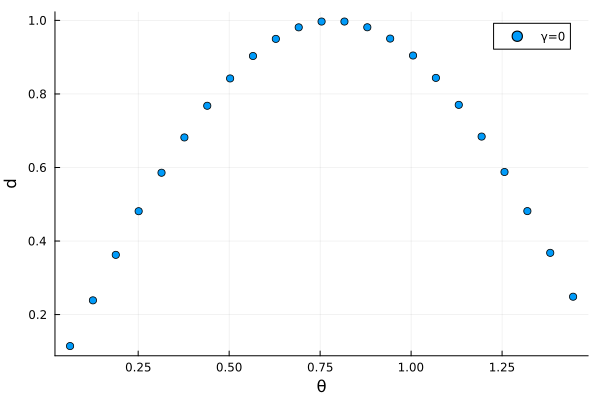

In [26]:
#My solution
thetas=collect(pi/50:pi/50:(pi/2-pi/50))
ds=[distance(initialv=(cos(theta),sin(theta)),m=1,g=1,gamma=0,delta=2,dt=0.1) for theta in thetas]
scatter(thetas,ds,xlabel="θ",ylabel="d",label="γ=0")

In [27]:
struct dual
    val
    deriv
end

Base.:*(a::dual,b)=dual(a.val*b,a.deriv*b)
Base.:*(b,a::dual)=dual(b*a.val,b*a.deriv)
Base.:*(a::dual,b::dual)=dual(a.val*b.val,a.deriv*b.val+a.val*b.deriv)
Base.:+(a::dual,b)=dual(a.val+b,a.deriv)
Base.:+(b,a::dual)=dual(b+a.val,a.deriv)
Base.:+(a::dual,b::dual)=dual(a.val+b.val,a.deriv+b.deriv)
Base.:-(a::dual,b)=dual(a.val-b,a.deriv)
Base.:-(b,a::dual)=dual(b-a.val,-a.deriv)
Base.:-(a::dual,b::dual)=dual(a.val-b.val,a.deriv-b.deriv)

Base.:>(a::dual,b)=a.val>b
Base.:<(a::dual,b)=a.val<b
Base.:>(b,a::dual)=b>a.val
Base.:<(b,a::dual)=b<a.val

Base.cos(a::dual)=dual(cos(a.val),-sin(a.val)*a.deriv)
Base.sin(a::dual)=dual(sin(a.val),cos(a.val)*a.deriv)

Base.:^(a::dual,b)=dual(a.val^b,b*a.val^(b-1)*a.deriv)

Base.:-(a::dual)=dual(-a.val,-a.deriv)

Base.:/(a::dual,b::dual)=dual(a.val/b.val,a.deriv/b.val-a.val/(b.val)^2*b.deriv)

In [28]:
function dist1(theta)
    initialv=(cos(theta),sin(theta))
    distance(initialv=initialv,m=1,g=1,gamma=0,delta=2,dt=0.1)
end

@time dist1(dual(0.5,1))

  0.238376 seconds (617.27 k allocations: 41.615 MiB, 2.25% gc time, 99.63% compilation time)


dual(0.8392128881777753, 1.1065987356432236)

Lets compare with our finite differences

In [29]:
@time approxder3(dist1,0.5,1e-4)

  0.000170 seconds (1.49 k allocations: 52.031 KiB)


1.1065987508519612

We could also look at the derivitive with respect to some other quantity -- say the strength of gravity

In [30]:
function dist2(g)
    initialv=(dual(1.,0.),dual(1.,0.))
    distance(initialv=initialv,m=1,g=g,gamma=0,delta=2,dt=0.1)
end

dist2(dual(9.8,1.))

dual(0.20275862068965514, -0.014268727705112963)

## Packages for Automatic Differentiation

In practice one would probably never write one own's automatic differentiation code.  The one we wrote worked fine for our purposes, but once you understand the principle it is nice to let someone else do the hard work 

In [31]:
using ForwardDiff

In [32]:
fd=ForwardDiff

ForwardDiff

In [33]:
@time fd.derivative(dist1,0.5)

  0.284034 seconds (1.20 M allocations: 81.228 MiB, 4.04% gc time, 99.84% compilation time)


1.1065987356432236

## Back Propegation / Backward AD

The algorithm that we developed is known as **forward pass automatic differentiation**.  There is an alternative algorithm known as **backward pass automatic differentiation**.

I may not have time to go through all of this section.  The punch line is that forward-pass is good for the case where you have a small number of inputs, and an arbitrary number of outputs.  It then efficiently calculates the derivatives of each of the outputs with respect to the input.  Backward-pass is good when you have many inputs and a small number of outputs.

To elaborate on this, lets think about chained unary operations $x->y->z->f$.

In forward pass we first calculate $dy/dx$ as a number, and then $dz/dx=dz/dy*dy/dx$, and then $df/dx=df/dz*dz/dx$.  We work from left to right.

In backward pass we first calculate $df/dz$ as a number.  Then we get the numerical value of $df/dy=df/dz*dz/dy$.  Finally we calculate $df/dx=df/dy*dy/dx$.  

The end result is the same: 
\begin{align}
\frac{df}{dx}&=\frac{df}{dz}\left(\frac{dz}{dy}\frac{dy}{dx}\right)\quad&\mbox{(forward)}\\
\frac{df}{dx}&=\left(\frac{df}{dz}\frac{dz}{dy}\right)\frac{dy}{dx}\quad&\mbox{(backward)}
\end{align}
\begin{align}
\end{align}
The only difference is the order in which the numbers are calculated.  As you will see, the book-keeping is easier for the forward algorithm -- thats what the dual number construction does.  

Suppose $x,y,z,f$ are vectors of length $N_x,N_y,N_z,N_f$.  In the forward algorithm we will be storing 
* $dy/dx$ -- a matrix of size $N_y\times N_x$
* $dz/dx$ -- a matrix of size $N_z\times N_x$
* $df/dx$ -- a matrix of size $N_f\times N_x$
  
Conversely, in the backward algorithm we need
* $df/dz$ -- a matrix of size $N_f\times N_z$
* $df/dy$ -- a matrix of size $N_f\times N_y$
* $df/dx$ -- a matrix of size $N_f\times N_x$
  
There are therefore likely to be efficiencies in the forward method if $N_x\ll N_f$.  Conversely, backward is probably better if $N_f\ll N_x$.

Our case is a little more complicated, as we are not just doing a simple chain of unary operations -- rather we are doing binary operations $+,-,*$.  Here is a sketch of what the Forward algorithm was doing when we calculated the derivative of $f(x)=(x+1)x(x-2)$ at $x=1$ -- where I name all the intermediate results

<img src="https://docs.google.com/drawings/d/e/2PACX-1vQaqU0DjOwLWcVgMLICbHpJp9z9pR8S5IPznZRjc2IpFGFHs8r3JuH4DMNJjDtl3KVg-fDltkZyecu4/pub?w=632&amp;h=718">

In that diagram, each operation is a box.  We track the derivative with respect to x of each intermediate result.  
We want to calculate $$f=(x+1)*x*(x-2)$$.  To do so we first calculate:

$$y_1=x+1=2\qquad \frac{dy_1}{dx}=\frac{dx}{dx} + \frac{d1}{dx}=1$$

which leaves us with $f=y_1*x*(x-2)$.  Next we calculate

$$y_2=x-2=-1\qquad \frac{dy_2}{dx}=\frac{dx}{dx}-\frac{d2}{dx}=1$$

which leads to $f=y_1*x*y_2$.  We then calculate

$$y_3=y_1*x=2\qquad \frac{dy_3}{dx}=\frac{d y_1}{dx}*x + y_1*\frac{d x}{dx}=3$$

Leaving us with

$$
f=y_3*y_2=-2\qquad \frac{df}{dx}=\frac{d y_3}{dx}y_2 + y_3 \frac{dy_2}{dx}-1.
$$


The magic of dual numbers is that all of the book-keeping is automatically taken care of.

Reverse auto-differentiation is similar, but we need to do more of the book-keeping by hand.  It is a two-pass algorithm.  In the *forward pass* we construct a flowchart, similar to the one I drew for the forward differentiation case, but storing slightly different information.  We then do a *backward pass* in which we use the stored information to extract the derivitive.

One advantage of the reverse method is that it automatically gives us not just the derivative with respect to the input -- but also the derivative with respect to all of the parameters in the function:  The '1' and '-2' in $f(x)=(x+{\color{red} 1})x(x{\color{red}-2})$.  This is important in applications like machine learning.

For many physics problems, forward mode AD works better than backwards mode.

For our problem, we will think of $f(x)=(x+1)x(x-2)$ as $f=(x_1+c_1)x_2(x_3-c_2)$, with $x_1=x_2=x_3=1$ and $c_1=1$, $c_2=2$.  In our forward pass we will generate a flowchart, keeping track of the derivatives of each operation with respect to its inputs:

<img src="https://docs.google.com/drawings/d/e/2PACX-1vSQoVBopHlggGfWhN0QN5vGCx61i3digc54XFMaIDLr-oMQd3oRu_freVfG4Z8AtE5__dyLXSonD2TL/pub?w=567&amp;h=719">

Thus we store:
\begin{align}
y_1&=x_1+c_1=2\quad &dy_1/dx_1&=1, &dy_1/dc_1&=1\\
y_2&=x_3-c_2=-1\quad &dy_2/dx_3&=1, &dy_2/dc_2&=-1\\
y_3&=y_1*x_3=2\quad &dy_3/dy_1&=1, &dy_3/dx_2&=2\\
f&=y_3*y_2=-1\quad &df/dy_3&=-1, &df/fy_2&=2
\end{align}

Next, we do a backward pass to generate $df/dz$ on the bond where $z$ is created.  This is a simple application of the chain rule.  Starting from the bottom, we know
$$
\frac{df}{dy_3}=-1
$$
We then go backwards to the node that generated it and use
$$
\frac{df}{dy_1}=\frac{df}{dy_3}\frac{dy_3}{dy_1}=(-1)*1=-1.
$$
In that way we generate the following graph:

<img src="https://docs.google.com/drawings/d/e/2PACX-1vQrTyyJyD75gJVgGkfto27JU4V-UlO7VuhLx15FelzFi0F2Gul55cHQc8SPJCng5GOT9l1Jpaf3MFG3/pub?w=568&amp;h=722">

We can then just read off $df/dx$ from the leaves at the top of the graph by adding up the contributions from all of the red arrows leading to it.  As promissed, we also, for free, get $df/c_1$ and $df/dc_2$.

Coding backward AD is a little more involved than coding forward AD.  As with `ForwardDiff.jl` there are some great packages which do it for us.  Nonetheless, here is a primitive implementation.

The first thing is that we need a data structure which stores our graph.  We will call each box in our flowchart a node.  It knows about the  inputs -- which we will call `parents`.  It will know about the derivitive of the output with respect to the input -- which we will call `local_derivatives`.  It will know the value of the output, `value`, and the derivative of `f` with respect to the output -- `derivatives`.

Note: I borrowed this code from [a forum post on discourse.julia.org](https://discourse.julialang.org/t/simple-implementation-of-reverse-mode-automatic-differentiation/78628)

In [34]:
mutable struct node
	value::Float64                     # Stores the value of the variable
	derivative::Float64                # Stores the value of derivative: df/dnode
	parents::Vector{node}              # Stores the input variables
	local_derivatives::Vector{Float64} # Local derivatives of outputs with respect to input variables

	function node(value)               # Constructor
		x = new()					    
		x.value = value
		x.derivative = 0.0             # Needs to be set during back-propegation
		x.parents = []
		x.local_derivatives = []
		return x
	end
end

function Base.:+(a::node, b::node)
	value = a.value + b.value
	C = node(value) 
	C.parents = [a, b]
	C.local_derivatives = [1.0, 1.0]  # [dC/da,dC/db]
	return C
end

function Base.:-(a::node, b::node)
	value = a.value - b.value
	C = node(value) 
	C.parents = [a, b]
	C.local_derivatives = [1.0, -1.0] # [dC/da,dC/db]
	return C
end

function Base.:*(a::node, b::node)
	value = a.value * b.value
	C = node(value) 
	C.parents = [a, b]
	C.local_derivatives = [b.value, a.value] # [dC/da,dC/db]
	return C
end

"""
    set_derivatives_to_zero!(C::node)
recursively follows the flowchart backwards, setting the the derivatives at all nodes to zero.  (When created nodes
have their derivative set to zero, but we may want to be able to reuse variables.  Certainly causes no harm.
"""
function set_derivatives_to_zero!(C::node)
	for i = 1:length(C.parents)
		C.parents[i].derivative = 0.0
		set_derivatives_to_zero!(C.parents[i])
	end
	return nothing
end

"""
   back_propegate!(C::node)
Propegates the derivitive backward through the flowchart
"""
function back_propegate!(C::node)
	for i = 1:length(C.parents)
		C.parents[i].derivative += C.derivative * C.local_derivatives[i] #df/di=df/dC dC/di
		back_propegate!(C.parents[i])
	end
	return nothing
end

"""
    calc_derivative!(f::node)
starts the back-propegation from the last node
"""
function calc_derivative!(f::node)
    set_derivatives_to_zero!(f)
    f.derivative=1.  #df/df=1
    back_propegate!(f)
    return nothing
end


calc_derivative!

In [35]:
xn=node(1)
c1n=node(1)
c2n=node(2)
fn=(xn+c1n)*xn*(xn-c2n);

In [36]:
fn.value

-2.0

In [37]:
calc_derivative!(fn)

In [38]:
xn.derivative # should give df/dx

-1.0

In [39]:
c1n.derivative # should give df/dc1

-1.0

In [40]:
c2n.derivative # should give df/dc2

-2.0